### Libraries

In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
import random
import pickle

from skimage.io import imread
from skimage.io import imshow
import skimage.transform as trans
from skimage import exposure
from skimage.util import crop

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, log_loss, roc_curve, auc
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.utils import resample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder, normalize

import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from keras.models import load_model


### Section 1. Data Loading , Further Preprocessing & Data Analysis

#### Data Loading and Data Imbalance Check

Data is loaded from the Alzheimer's Dataset folder into train_images along with the number of images with a gray-scale filter

In [16]:
#Preparation of complete dataset without downsampled size

#For simplicity in our code for splitting -
#the test_data set from the original Kaggle datasets have been merged with the train_set

train_path = 'Alzheimer_s Dataset'

categories = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

train_images = []
original_labels = []

#Number of train_images of each category for our train_data
numberofimages = []

#similar to rmarkdown to get file directories
for category in categories:
    data_train_path = os.path.join(train_path, category)
    #store the number of images for each label in a list
    numberofimages.append(len(os.listdir(data_train_path)))

    for file in os.listdir(data_train_path):
        original_labels.append(category)
        train_image_paths = os.path.join(data_train_path, file) #image in this case refers to title of the image
        train_image = imread(train_image_paths, as_gray=True) #reads an image, imread - image + read and grayscales all train_images)
        train_images.append(train_image)

We can see that there is a significant class imbalance which calls for the need of data augmentation for the training set obtained using the function train_test_split which is done is Section 2.

[3200, 2240, 896, 64]


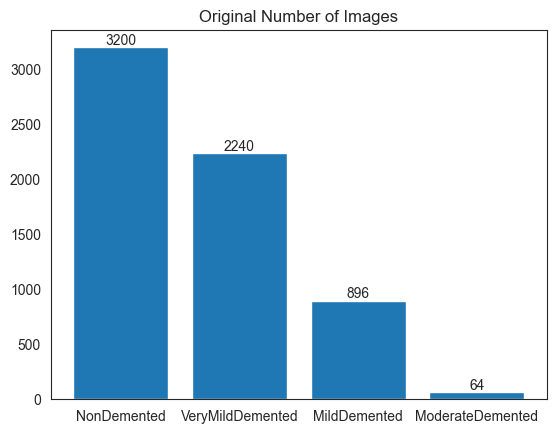

In [17]:
# Number of images for each data label / category within training data
print(numberofimages)

#Plot showing class imbalance
sns.set_style('white')
barplot = plt.bar(categories, numberofimages)
plt.title('Original Number of Images')
plt.bar_label(barplot , labels = numberofimages)
plt.show()

In [18]:
# Splitting of training dataset into a list of its respective categories
NonDemented = train_images[0:3200]
VeryMildDemented = train_images[3200:5440]
MildDemented = train_images[5440:6336]
ModerateDemented = train_images[6336:]

lst = [NonDemented, VeryMildDemented, MildDemented, ModerateDemented]

In [19]:
#Check dimensions of each raw data set
print(f"The dimensions of each image is : {train_images[0].shape}")

#Check if all data-set has the same dimensions
dim = train_images[0].shape
sum_of_incorrect = 0

for i in train_images:
    if i.shape != dim:
        sum_of_incorrect+=1

print(f"Number of images with incorrect dimensions are: {sum_of_incorrect}")

The dimensions of each image is : (208, 176)
Number of images with incorrect dimensions are: 0


#### Further Preprocessing and Data Analysis

##### Image Adjustments - Preprocessing

Since data has already been preprocessed as mentioned in Kaggle to the same headshape, further preprocessing will be done such as cropping the image to reduce the redundant features and decrease model training time.

As seen below, the image can be further cropped. From the dimensions, we can approximate the crop size for to be (25,175) for both X and Y axis

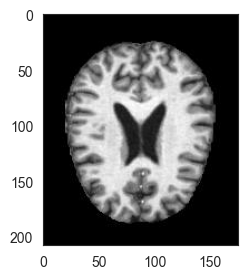

In [20]:
plt.figure(figsize = (3,3))
plt.imshow(train_images[0], cmap = 'gray')
plt.show()

We will manually set the dimensions, testing it on one image before doing it for all images. Upon testing, a dimension from y = (20:195) and x = (15:160) appears to be ideal with some allowance for the slightly different head sizes.

New dimensions of test_image is : (175, 145)


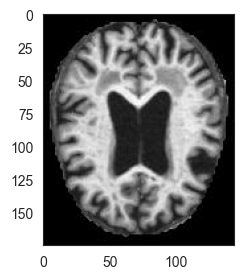

In [21]:
imageTest = train_images[100][20:195, 15:160]
print(f'New dimensions of test_image is : {imageTest.shape}')
plt.figure(figsize = (3,3))
plt.imshow(imageTest, cmap = 'gray')
plt.show()

In [22]:
#Cropping of images
for i in range(len(train_images)):
    new_cropped_image = train_images[i][20:195,15:160]
    train_images[i] = new_cropped_image

#For lst that is split into categories(Needed to make data viz simpler)
for category in lst:
    for i in range(len(category)):
        new_cropped_image = category[i][20:195, 15:160]
        category[i] = new_cropped_image


5 Samples of images from each category is shown. It is obvious that some images are darker than others such as the third picture under VeryMildDemented.

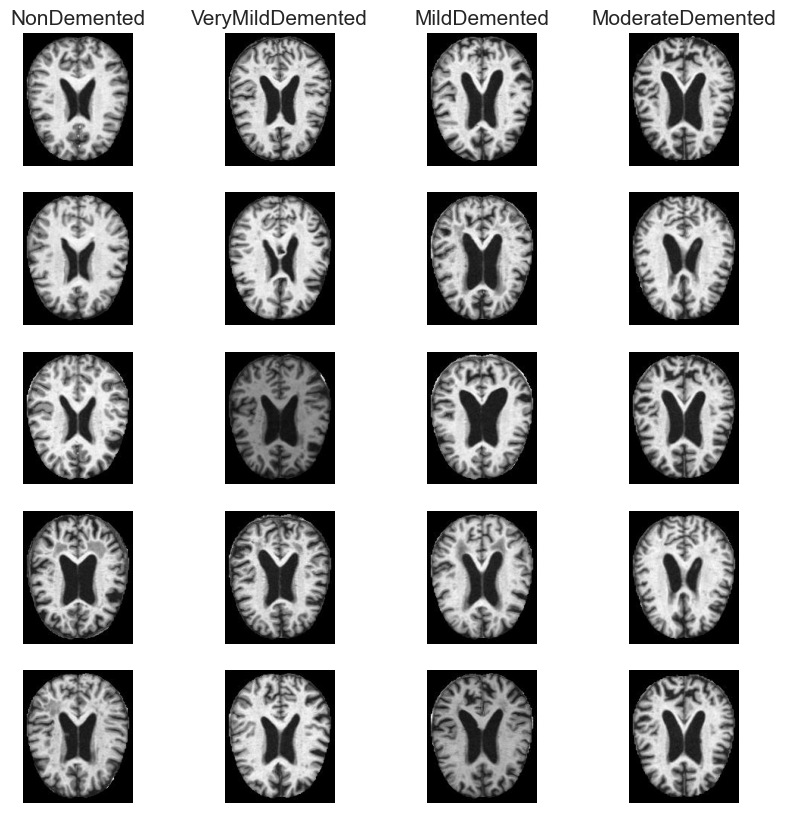

In [23]:
#First 4 pictures to roughly show how each MRI Scan for each category looks like using the original dataset
fig,axes = plt.subplots(5,4, figsize = (10,10))

for i in range(len(lst)):
    for j in range(5):
        img = lst[i][j]
        axes[j,i].imshow(img, cmap = 'gray')
        axes[j,i].axis('off') #turn off axis for each subplot
axes[0,0].set_title('NonDemented', fontsize = 15)
axes[0,1].set_title('VeryMildDemented', fontsize = 15)
axes[0,2].set_title('MildDemented', fontsize = 15)
axes[0,3].set_title('ModerateDemented', fontsize = 15)
plt.show()

We can do intensity normalization via adaptive histogram equalization for images with low contrast with a large kernel size of 80 x 80 to try and prevent black pixels from also getting equalized.

In [25]:
storedImage = lst[1][2] #For Comparison

In [24]:
#function to run for hist eq
def hist_eq(image):
    if (exposure.is_low_contrast(image, fraction_threshold = 0.80)): #Only if contrast is low enough, then we perform equalization
        image = exposure.equalize_adapthist(image, clip_limit=0.009, kernel_size = (80,80))
    return image

In [26]:
for i in range(len(train_images)):
    train_images[i] = hist_eq(train_images[i])

#For lst that is split into categories(Needed to make data viz simpler)
for category in lst:
    for i in range(len(category)):
        category[i] = hist_eq(category[i])        


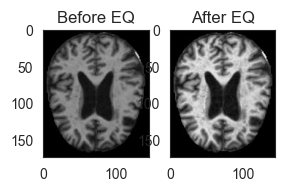

In [27]:
fig, axes = plt.subplots(1,2, figsize = (3,3))
axes[0].imshow(storedImage, cmap = 'gray')
axes[1].imshow(lst[1][2], cmap = 'gray')

#Titles
axes[0].set_title('Before EQ')
axes[1].set_title('After EQ')
plt.show()

After Equalization(CLAHE), do normalization of images to ensure pixel values are on the same scale of [0,1]

We can see below that some pixels are on a scale of [0,1] whereas others are [0,255]

In [29]:
scale_1 = 0
scale_2 = 0
for i in range(len(train_images)):
    if np.max(train_images[i]) == 1:
        scale_1 += 1
    if np.max(train_images[i]) == 255:
        scale_2 +=1
print(f'The number of images on a [0,1] scale is approximately: {scale_1}')
print(f'The number of images on a [0,255] scale is approximately: {scale_2}')

The number of images on a [0,1] scale is approximately: 433
The number of images on a [0,255] scale is approximately: 4302


In [30]:
def normalisation(image):
    p_min = np.min(image)
    p_max = np.max(image)
    image = (image - p_min) / (p_max - p_min)
    return image

In [31]:
for i in range(len(train_images)):
    train_images[i] = normalisation(train_images[i])


for category in lst:
    for i in range(len(category)):
        category[i] = normalisation(category[i])  

##### Pixel Analysis

Let's now analyse the the frequency of each pixel for 40 images using a histogram.


In [32]:
frequency = []
for categories in lst:
    total = 0 #Starting np array
    flat = []
    for image_idx in range(40):
        total += categories[image_idx] / 40
        flat.extend(total.flatten())
    frequency.append(flat)



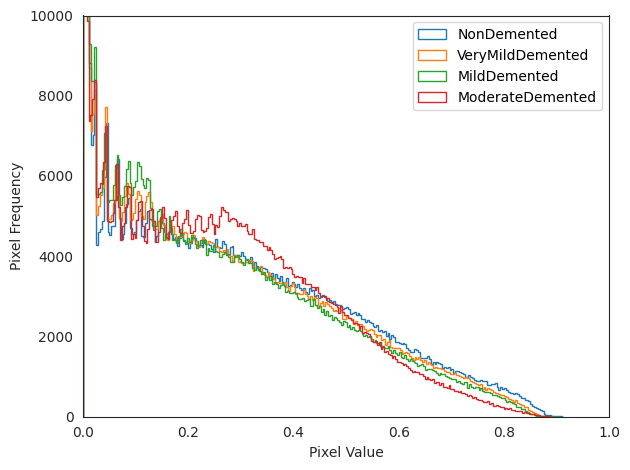

In [33]:
for i in range(len(frequency)):
    plt.hist(frequency[i], bins = 256, histtype = 'step')
    plt.xlim(0,1)
    plt.ylim(0,10000)

plt.style.use('default')
plt.xlabel('Pixel Value')
plt.ylabel('Pixel Frequency')
plt.legend(('NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented'))
plt.tight_layout()

plt.show()

There appears to be no correlation with pixel frequency and the class labels for Alzheimer detection(Not Severity Classification). But there seems to be a difference in pixel values between 0.2 to 0.4 for ModerateDemented.

Thus, it might be a good idea to use a binary mask filter before running the dataset through mcSVM models for classification of severity on whether one has Alzheimer's, we can apply a binary filter from pixel 0.2 to 0.6


### Section 2: Data Preparation 

For reference:  Our new training set for the base images is:

X_train_augmented

y_train_augmented

##### Upsampling of Data

Before doing any data augmentation, we will first split the data into train and test sets to prevent data leakage.

In [36]:
X_train_base, X_test_base, y_train_base, y_train_test = train_test_split(train_images,  original_labels, random_state=9)

These are the functions we need for augmentation. It is done by rotating our images slightly to maintain a somewhat straight orientation of photos.

In [34]:
def moderate_augmentation(image, label, training_images, training_labels):
    training_images.append(trans.rotate(image, 348))
    training_images.append(trans.rotate(image, 5))
    training_images.append(trans.rotate(image,355))
    training_images.append(trans.rotate(image, 8))
    training_images.append(trans.rotate(image, 362))
    training_images.append(trans.rotate(image, 3))
    training_images.append(trans.rotate(image,357))
    training_images.append(trans.rotate(image,350))
    training_images.append(trans.rotate(image,352))
    training_images.append(trans.rotate(image,10))
    training_images.append(trans.rotate(image,348))
    training_images.append(trans.rotate(image,345))
    training_images.append(trans.rotate(image,15))
    training_images.append(trans.rotate(image,12))
    training_images.append(trans.rotate(image[::-1], 180))

    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)

    

def mild_augmentation(image, label, training_images, training_labels):
    training_images.append(trans.rotate(image, 348))
    training_images.append(trans.rotate(image, 5))
    training_images.append(trans.rotate(image,355))

    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)

Here, we will check the how bad the class imbalance is in our training set and do data augmentation accordingly.

In [38]:
training_lst = []
NonDemented_train = []
VeryMildDemented_train = []
MildDemented_train= []
ModerateDemented_train = []
train_numberofImages = []


for i in range(len(X_train_base)):
    if y_train_base[i] == 'NonDemented':
        NonDemented_train.append(X_train_base[i])

    if y_train_base[i] == 'VeryMildDemented':
        VeryMildDemented_train.append(X_train_base[i])

    if y_train_base[i] == 'MildDemented':
        MildDemented_train.append(X_train_base[i])

    if y_train_base[i] == 'ModerateDemented':
        ModerateDemented_train.append(X_train_base[i])

training_lst.append(NonDemented_train)
train_numberofImages.append(len(NonDemented_train))

training_lst.append(VeryMildDemented_train)
train_numberofImages.append(len(VeryMildDemented_train))

training_lst.append(MildDemented_train)
train_numberofImages.append(len(MildDemented_train))

training_lst.append(ModerateDemented_train)
train_numberofImages.append(len(ModerateDemented_train))

MildDemented and ModerateDemented are very unbalanced compared to NonDemented and VeryMildDemented. We will do upsampling here to retain as much information as possible.

In [39]:
categories = ('NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented')

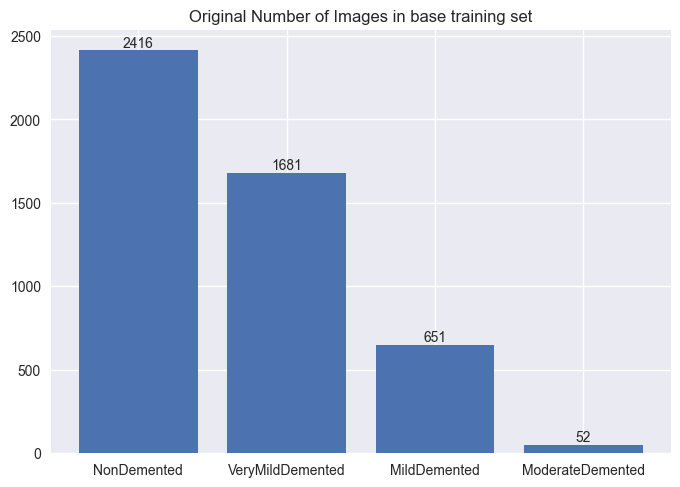

In [40]:
plt.style.use('seaborn')
barplot = plt.bar(categories, train_numberofImages)
plt.title('Original Number of Images in base training set')
plt.bar_label(barplot , labels = train_numberofImages)
plt.show()

In [41]:
#Upsampling
X_train_augmented = []
y_train_augmented = []
for i in range(len(X_train_base)):
    if y_train_base[i] == 'ModerateDemented':
        moderate_augmentation(X_train_base[i], y_train_base[i], X_train_augmented, y_train_augmented)
    if y_train_base[i] == 'MildDemented':
        mild_augmentation(X_train_base[i], y_train_base[i], X_train_augmented, y_train_augmented)
    else:
        X_train_augmented.append(X_train_base[i])
        y_train_augmented.append(y_train_base[i])

In [42]:
print(len(y_train_augmented))
print(len(X_train_augmented))

6882
6882


In [43]:
## Just to get the number of images and to split it into its respective category
training_lst_aug = []
NonDemented_train_aug = []
VeryMildDemented_train_aug = []
MildDemented_train_aug = []
ModerateDemented_train_aug = []
train_numberofImages_aug = []


for i in range(len(X_train_augmented)):
    if y_train_augmented[i] == 'NonDemented':
        NonDemented_train_aug.append(X_train_augmented[i])

    if y_train_augmented[i] == 'VeryMildDemented':
        VeryMildDemented_train_aug.append(X_train_augmented[i])

    if y_train_augmented[i] == 'MildDemented':
        MildDemented_train_aug.append(X_train_augmented[i])

    if y_train_augmented[i] == 'ModerateDemented':
        ModerateDemented_train_aug.append(X_train_augmented[i])

training_lst_aug.append(NonDemented_train_aug)
train_numberofImages_aug.append(len(NonDemented_train_aug))

training_lst_aug.append(VeryMildDemented_train_aug)
train_numberofImages_aug.append(len(VeryMildDemented_train_aug))

training_lst_aug.append(MildDemented_train_aug)
train_numberofImages_aug.append(len(MildDemented_train_aug))

training_lst_aug.append(ModerateDemented_train_aug)
train_numberofImages_aug.append(len(ModerateDemented_train_aug))

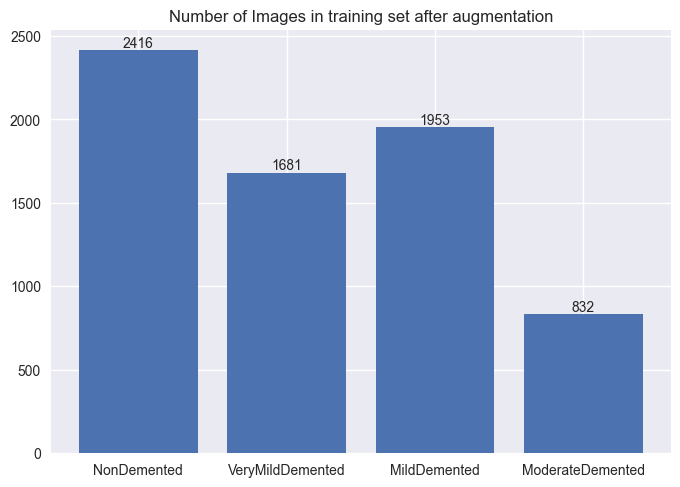

In [44]:
plt.style.use('seaborn')
barplot = plt.bar(categories, train_numberofImages_aug)
plt.title('Number of Images in training set after augmentation')
plt.bar_label(barplot , labels = train_numberofImages_aug)
plt.show()

After augmentation, the number of ModerateDemented has increased to 832 samples and MildDemented to 1953 samples.

Below is an image of how our data looks like after rotation.

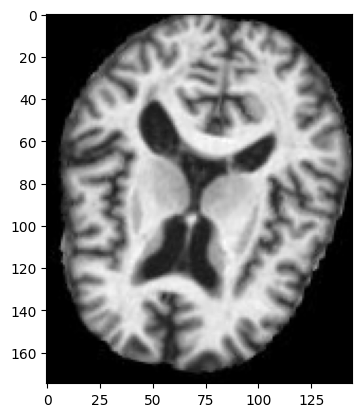

In [45]:
plt.style.use('default')
plt.imshow(ModerateDemented_train_aug[10], cmap = 'gray')
plt.show()

#### Preparing training data for linear models

We will prepare 2 additional training and test data set with a binary filter applied and with linear discriminant analysis for feature reduction.

##### Applying binary filter

We can apply a binary filter over a range (50,175), which is [0.2,0.6] in a [0-1] scale, to see if its meaningful features selected as there is data variation in that region, especially for ModerateDemented.

 We can use this training data for our linear models for detection to see if it is meaningful for detection as well.

In [46]:
binaryX_train_nonFlat = []
binaryX_train = [] #Our actual training set

#We will apply filter but leave this untouched
binaryX_test = []

for image in X_train_augmented:
    img = np.where((image >= 0.2) & (image<= 0.6), 1,0)
    binaryX_train_nonFlat.append(img)
    binaryX_train.append(img.flatten())

#DO NOT TOUCH until model prediction
for image in X_test_base:
    img = np.where((image >= 0.2) & (image<= 0.6), 1,0)
    binaryX_test.append(img.flatten())

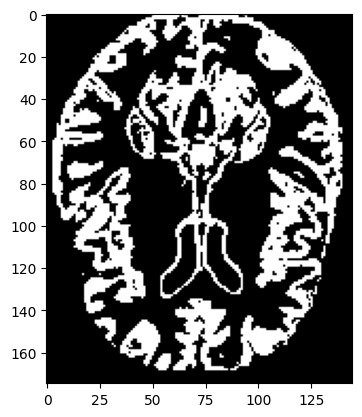

In [48]:
#Image after binary mask application
plt.style.use('default')
plt.imshow(binaryX_train_nonFlat[1], cmap = 'gray')
plt.show()

One potential improvement is by performing LDA on our dataset to speed up linear model training time. Additionally, LDA helps increase linear separability in our data, and mitigates the curse of dimensionality since we are dealing with complex image data, therefore reducing the dimensionality of the data. This only works with flattened images so we will first flatten our train_images.

In [53]:
baseX_train = []
baseX_test = []
baseY_train = y_train_augmented
baseY_test = y_train_test

for i in X_train_augmented:
    baseX_train.append(i.flatten())

for i in X_test_base:
    baseX_test.append(i.flatten())

LDA Training set

In [56]:
lda = LinearDiscriminantAnalysis()
lda_baseX_train = lda.fit_transform(baseX_train, y_train_augmented)
lda_baseX_test = lda.transform(baseX_test)

Creating one-hot encoded labels for detection

In [57]:
classificationLabels = np.where(np.array(y_train_augmented) == 'NonDemented', 0, 1)

In [61]:
#Checking if all X_train sets have same dimensions(excluding LDA)

for i in baseX_train:
    if len(i) != 25375:
        print('y')

for i in binaryX_train:
    if len(i) != 25375:
        print('y')

#### Preparation for CNN Model and mcSVM models

We will create two subsets of training data based on the original training set. Similar to the above, one with a binary mask and one without only for the mcSVM dataSet

The first will be the training set will be the CNN training data that has been reshaped to fit the keras model. This set includes both Demented and NonDemented pictures.

The second will be the training set for our multi-class SVM model for classification of the severity of Alzheimers. This set includes only Demented pictures.

In [96]:
#CNN data
baseImages3D = X_train_augmented.copy() #Creates a new coppy
baseImages3D = np.array(baseImages3D).reshape(-1, 175,145,1)
cnn_X_train = baseImages3D

This does one-hot encoding for the CNN data.

[0,0,1,0] refers to NonDemented

[0,0,0,1] refers to VeryMildDemented

[1,0,0,0] refers to Mild Demented

[0,1,0,0] refers to ModerateDemented


In [68]:
labelsGet = pd.get_dummies(y_train_augmented)
cnn_labels = labelsGet.values

In [70]:
cnn_labels

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]], dtype=uint8)

In [77]:
#mcSVM dataset
#Here, we will remove NonDemented datasets
mcSVM_images = []
for cat in training_lst_aug[1:]:
    for images in cat:
        mcSVM_images.append(images.flatten())

mcSVM_lab = []
for i in range(len(categories)-1):
    mcSVM_lab.extend(np.repeat(categories[i+1], train_numberofImages_aug[i+1]))


In [80]:
#binary_images for mc_SVM
binary_mcSVM = []
for i in range(len(y_train_augmented)):
    if y_train_augmented[i] != 'NonDemented':
        binary_mcSVM.append(binaryX_train[i])

Making Labels for mcSVM. This automatically does one-hot encoding

In [79]:
le = LabelEncoder()
le.fit(mcSVM_lab)
mcSVM_labels = le.transform(mcSVM_lab)

### Section 3. Model Training

#### Linear Models for Dectection (Binary Classification)

Models will follow this format: Base set, Binary set, LDA set using a KFold of 5. For models using base_images(except LDA), we will tune the hyper-parameters using GridSearchCV for the base models

In [85]:
#Default is 5
kf = KFold()

##### Logistic Regression Models

In [90]:
logregBase_parameters = {'penalty': ['l1','l2'], 'C': list(np.linspace(0.00001,2, num = 5))}

#run logistic regression models
logregBase = GridSearchCV(LogisticRegression(random_state = 9,max_iter = 100), logregBase_parameters, cv = kf) 
logregBase.fit(baseX_train,baseY_train)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(random_state=9),
             param_grid={'C': [1e-05, 0.5000074999999999, 1.000005, 1.5000025,
                               2.0],
                         'penalty': ['l1', 'l2']})

In [91]:
logregBinary = LogisticRegressionCV(cv = kf, random_state= 9)
logregBinary.fit(binaryX_train, y_train_augmented)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

LogisticRegressionCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                     random_state=9)

In [92]:
logregLDA = LogisticRegressionCV(cv = kf, random_state= 9)
logregLDA.fit(lda_baseX_train, baseY_train)

LogisticRegressionCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                     random_state=9)

In [94]:
##Save the models
pickle.dump(logregBase , open('logregBase.pkl' , 'wb'))
pickle.dump(logregBinary , open('logregBinary.pkl' , 'wb'))
pickle.dump(logregLDA, open('logregLDA.pkl' , 'wb'))

In [123]:
with open ('logregBase.pkl', 'rb') as file:
    lrBase = pickle.load(file)

with open ('logregBinary.pkl', 'rb') as file:
    lrBinary = pickle.load(file)

with open ('logregLDA.pkl', 'rb') as file:
    lrLDA = pickle.load(file)

##### Logistic Regression Results

In [124]:
lrBase_ypred_test = lrBase.predict(baseX_test)
lrBase_ypred_train = lrBase.predict(baseX_train)

In [102]:
print(f"Base Logistic Regression Prediction Probability: {np.mean(lrBase_ypred)}")
print(f"Actual Probability: {np.mean(baseY_test)}")

print(f"Binary Logistic Regression Prediction Probability: {np.mean(lrBinary_ypred)}")
print(f"Actual Probability: {np.mean(binaryY_test)}")

print(f"LDA Logistic Regression Prediction Probability: {np.mean(lrLDA_ypred)}")
print(f"Actual Probability: {np.mean(baseY_test)}")

Base Logistic Regression Prediction Probability: 0.649103139013453
Actual Probability: 0.6401345291479821
Binary Logistic Regression Prediction Probability: 0.655829596412556
Actual Probability: 0.6401345291479821
LDA Logistic Regression Prediction Probability: 0.6334080717488789
Actual Probability: 0.6401345291479821


Results

Checking for Model Fit

Bias-Variance Trade-off

In [58]:
#Evaluating the model via evaluative metrics

print("Base Logistic Regression Metrics for Training Data")

logregBase_cm_train = confusion_matrix(baseY_train, lrBase_ypred_train)
print(logregBase_cm_train)

print(classification_report(baseY_train, lrBase_ypred_train))

print("Base Logistic Regression Metrics for Test Data")

logregBase_cm_test = confusion_matrix(baseY_test, lrBase_ypred_test)
print(logregBase_cm_test)

print(classification_report(baseY_test, lrBase_ypred_test))

Base Logistic Regression Metrics for Training Data
[[1191   84]
 [  57 2232]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1275
           1       0.96      0.98      0.97      2289

    accuracy                           0.96      3564
   macro avg       0.96      0.95      0.96      3564
weighted avg       0.96      0.96      0.96      3564

Base Logistic Regression Metrics for Test Data
[[302  19]
 [ 11 560]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       321
           1       0.97      0.98      0.97       571

    accuracy                           0.97       892
   macro avg       0.97      0.96      0.96       892
weighted avg       0.97      0.97      0.97       892



In [104]:
logregBase_residuals_train = baseY_train - lrBase_ypred_train
logregBase_var_train = np.var(logregBase_residuals_train)
print(f"Logistic Regression Base Variance (Training Data): {logregBase_var_train}")

logregBase_residuals_test = baseY_test - lrBase_ypred_test
logregBase_var_test = np.var(logregBase_residuals_test)
print(f"Logistic Regression Base Variance (Test Data): {logregBase_var_test}")

Logistic Regression Base Variance (Training Data): 0.039504897459442904
Logistic Regression Base Variance (Test Data): 0.033551851032596676


In [65]:
logregBase_train_loss = log_loss(baseY_train, lrBase_ypred_train)
print(f"Logistic Regression Base Loss (Train): {logregBase_train_loss}")

logregBase_test_loss = log_loss(baseY_test, lrBase_ypred_test)
print(f"Logistic Regression Base Loss (Test): {logregBase_test_loss}")

Logistic Regression Base Loss (Train): 1.4259694522630524
Logistic Regression Base Loss (Test): 1.21223049514968


In [49]:
lrBase_validation_scores = cross_val_score(lrBase, baseX_test, baseY_test, cv=5, scoring='accuracy')
print(lrBase_validation_scores.mean())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

KeyboardInterrupt: 

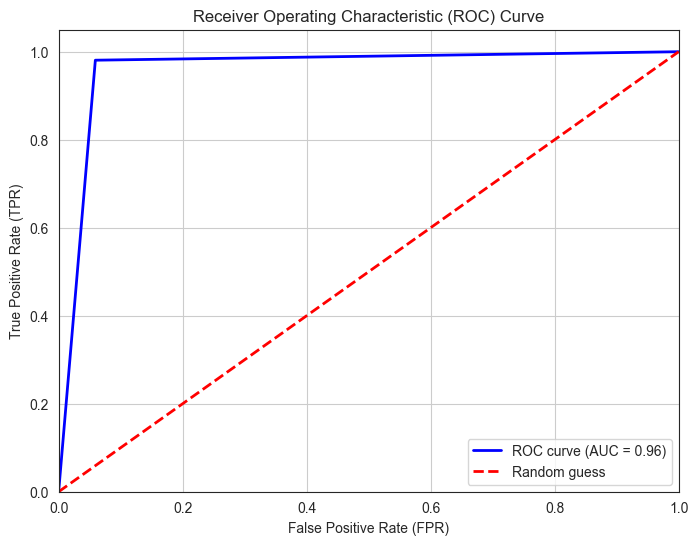

In [103]:
#ROC-AUC curve
logregBase_fpr, logregBase_tpr, logregBase_thresholds = roc_curve(baseY_test, lrBase_ypred_test)
roc_auc = auc(logregBase_fpr, logregBase_tpr)

plt.figure(figsize=(8, 6))
plt.plot(logregBase_fpr, logregBase_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [105]:
lrBinary_ypred_test = lrBinary.predict(binaryX_test)
lrBinary_ypred_train = lrBinary.predict(binaryX_train)

In [107]:
print("Binary Logistic Regression Metrics for Training Data")

logregBinary_cm_train = confusion_matrix(y_train_augmented, lrBinary_ypred_train)
print(logregBinary_cm_train)

print(classification_report(y_train_augmented, lrBinary_ypred_train))

print("Binary Logistic Regression Metrics for Test Data")

logregBinary_cm_test = confusion_matrix(y_train_augmented, lrBinary_ypred_test)
print(logregBinary_cm_test)

print(classification_report(y_train_augmented, lrBinary_ypred_test))

Binary Logistic Regression Metrics for Training Data
[[1149  126]
 [  82 2207]]
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      1275
           1       0.95      0.96      0.95      2289

    accuracy                           0.94      3564
   macro avg       0.94      0.93      0.94      3564
weighted avg       0.94      0.94      0.94      3564

Binary Logistic Regression Metrics for Test Data
[[292  29]
 [ 15 556]]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       321
           1       0.95      0.97      0.96       571

    accuracy                           0.95       892
   macro avg       0.95      0.94      0.95       892
weighted avg       0.95      0.95      0.95       892



In [109]:
logregBinary_residuals_train = baseY_train - lrBinary_ypred_train
logregBinary_var_train = np.var(logregBinary_residuals_train)
print(f"Binary Logistic Regression Variance (Training Data): {logregBinary_var_train}")

logregBinary_residuals_test = baseY_test - lrBinary_ypred_test
logregBinary_var_test = np.var(logregBinary_residuals_test)
print(f"Binary Logistic Regression Variance (Test Data): {logregBinary_var_test}")

Binary Logistic Regression Variance (Training Data): 0.05820897590444918
Binary Logistic Regression Variance (Test Data): 0.04908101912365018


In [112]:
logregBinary_loss_train = log_loss(y_train_augmented, lrBinary_ypred_train)
print(f"Logistic Regression Binary Loss (Train): {logregBinary_loss_train}")

logregBinary_loss_test = log_loss(y_train_augmented, lrBinary_ypred_test)
print(f"Logistic Regression Binary Loss (Test): {logregBinary_loss_test}")

Logistic Regression Binary Loss (Train): 2.1035577735511692
Logistic Regression Binary Loss (Test): 1.777938059552864


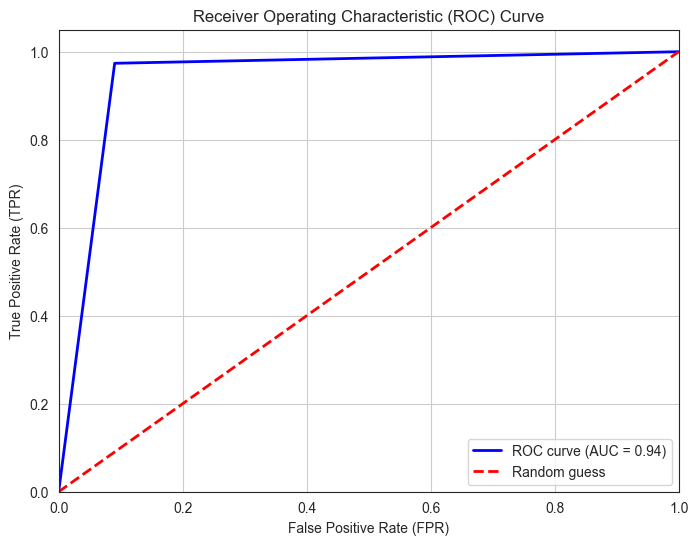

In [113]:
#ROC-AUC curve
logregBinary_fpr, logregBinary_tpr, logregBinary_thresholds = roc_curve(baseY_test, lrBinary_ypred_test)
roc_auc = auc(logregBinary_fpr, logregBinary_tpr)

plt.figure(figsize=(8, 6))
plt.plot(logregBinary_fpr, logregBinary_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
#plt.show()

In [114]:
lrLDA_ypred_test = lrLDA.predict(lda_baseX_test)
lrLDA_ypred_train = lrLDA.predict(lda_baseX_train)

In [117]:
lda_cm_train = confusion_matrix(baseY_train, lrLDA_ypred_train)
print(lda_cm_train)

print(classification_report(baseY_train, lrLDA_ypred_train))

lda_cm_test = confusion_matrix(baseY_test, lrLDA_ypred_test)
print(lda_cm_test)

print(classification_report(baseY_test, lrLDA_ypred_test))

[[1264   11]
 [  15 2274]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1275
           1       1.00      0.99      0.99      2289

    accuracy                           0.99      3564
   macro avg       0.99      0.99      0.99      3564
weighted avg       0.99      0.99      0.99      3564

[[274  47]
 [ 53 518]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       321
           1       0.92      0.91      0.91       571

    accuracy                           0.89       892
   macro avg       0.88      0.88      0.88       892
weighted avg       0.89      0.89      0.89       892



In [120]:
logregLDA_residuals_train = baseY_train - lrLDA_ypred_train
logregLDA_var_train = np.var(logregLDA_residuals_train)
print(f"Logistic Regression Base Variance (Training Data): {logregLDA_var_train}")

logregLDA_residuals_test = baseY_test - lrLDA_ypred_test
logregLDA_var_test = np.var(logregLDA_residuals_test)
print(f"Logistic Regression Base Variance (Test Data): {logregLDA_var_test}")

Logistic Regression Base Variance (Training Data): 0.00729391432721025
Logistic Regression Base Variance (Test Data): 0.11206237808924371


In [125]:
logregLDA_loss_train = log_loss(baseY_train, lrLDA_ypred_train)
print(f"LDA Logistic Regression Loss (Train): {logregLDA_loss_train}")

logregLDA_loss_test = log_loss(baseY_test, lrLDA_ypred_test)
print(f"LDA Logistic Regression Loss (Test): {logregLDA_loss_test}")

LDA Logistic Regression Loss (Train): 0.2629447216938964
LDA Logistic Regression Loss (Test): 4.0407683171656


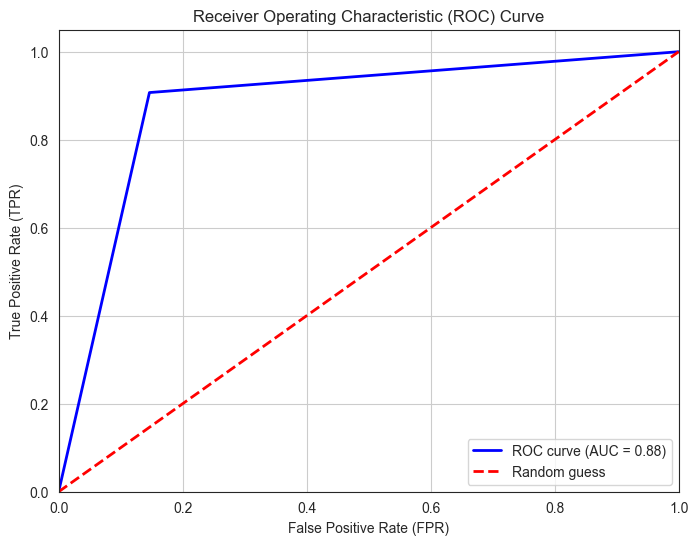

In [121]:
#ROC-AUC curve
logregLDA_fpr, logregLDA_tpr, logregLDA_thresholds = roc_curve(baseY_test, lrLDA_ypred_test)
roc_auc = auc(logregLDA_fpr, logregLDA_tpr)

plt.figure(figsize=(8, 6))
plt.plot(logregLDA_fpr, logregLDA_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

##### SVM Models using Linear Kernel

In [ ]:
base_svm = LinearSVC(max_iter = 100)
base_svm.fit(baseX_train, baseY_train)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the w

LinearSVC()

In [ ]:
binary_svm = LinearSVC(max_iter = 100)
binary_svm.fit(binaryX_train, y_train_augmented)

In [ ]:
lda_svm = LinearSVC()
lda_svm.fit(baseX_train, baseY_train)

In [21]:
with open ('base_svm.pkl', 'rb') as file:
    baseSVM = pickle.load(file)

with open ('binary_svm.pkl', 'rb') as file:
    binarySVM = pickle.load(file)

with open ('lda_svm.pkl', 'rb') as file:
    ldaSVM = pickle.load(file)

##### Base SVM Model Evaluation

In [80]:
baseSVM_ypred_train = baseSVM.predict(baseX_train)
baseSVM_ypred_test = baseSVM.predict(baseX_test)

In [29]:
print(f"Base SVM Prediction Probability: {np.mean(baseSVM_ypred)}")
print(f"Actual Probability: {np.mean(baseY_test)}")

binarySVM_ypred = binarySVM.predict(binaryX_test)
print(f"Binary SVM Prediction Probability: {np.mean(binarySVM_ypred)}")
print(f"Actual Probability: {np.mean(binaryY_test)}")

ldaSVM_ypred = ldaSVM.predict(baseX_test)
print(f"LDA SVM Prediction Probability: {np.mean(ldaSVM_ypred)}")
print(f"Actual Probability: {np.mean(baseY_test)}")

Base SVM Prediction Probability: 0.649103139013453
Actual Probability: 0.6401345291479821
Binary SVM Prediction Probability: 0.6547085201793722
Actual Probability: 0.6401345291479821
LDA SVM Prediction Probability: 0.647982062780269
Actual Probability: 0.6401345291479821


In [82]:
print("Base SVM Metrics for Training Data")

svmBase_cm_train = confusion_matrix(baseY_train, baseSVM_ypred_train)
print(svmBase_cm_train)

print(classification_report(baseY_train, baseSVM_ypred_train))

print("Base SVM Metrics for Test Data")

svmBase_cm_test = confusion_matrix(baseY_test, baseSVM_ypred_test)
print(svmBase_cm_test)

print(classification_report(baseY_test, baseSVM_ypred_test))

Base SVM Metrics for Training Data
[[1196   79]
 [  41 2248]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1275
           1       0.97      0.98      0.97      2289

    accuracy                           0.97      3564
   macro avg       0.97      0.96      0.96      3564
weighted avg       0.97      0.97      0.97      3564

Base SVM Metrics for Test Data
[[303  18]
 [ 10 561]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       321
           1       0.97      0.98      0.98       571

    accuracy                           0.97       892
   macro avg       0.97      0.96      0.97       892
weighted avg       0.97      0.97      0.97       892



In [84]:
base_SVM_residuals_train = baseY_train - baseSVM_ypred_train
base_SVM_var_train = np.var(base_SVM_residuals_train)
print(f"Base SVM Variance (Train): {base_SVM_var_train}")

base_SVM_residuals_test = baseY_test - baseSVM_ypred_test
base_SVM_var_test = np.var(base_SVM_residuals_test)
print(f"Base SVM Variance (Test): {base_SVM_var_test}")

Base SVM Variance (Train): 0.033556351644641956
Base SVM Variance (Test): 0.03130969856622896


In [89]:
base_SVM_decision_scores_train = baseSVM.decision_function(baseX_train)
base_SVM_hinge_loss_train = np.maximum(0, 1 - baseSVM_ypred_train * base_SVM_decision_scores_train).mean()
print(f"Base SVM Hinge Loss (Train): {base_SVM_hinge_loss_train}")

base_SVM_decision_scores_test = baseSVM.decision_function(baseX_test)
base_SVM_hinge_loss_test = np.maximum(0, 1 - baseSVM_ypred_test * base_SVM_decision_scores_test).mean()
print(f"Base SVM Hinge Loss (Test): {base_SVM_hinge_loss_test}")

Base SVM Hinge Loss (Train): 0.38873271479348104
Base SVM Hinge Loss (Test): 0.38456076623892926


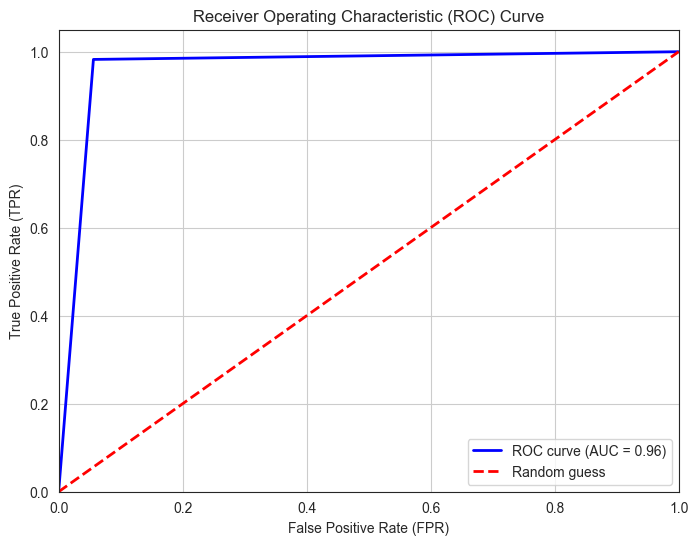

In [90]:
#ROC-AUC curve
baseSVM_fpr, baseSVM_tpr, baseSVM_thresholds = roc_curve(baseY_test, baseSVM_ypred_test)
roc_auc = auc(baseSVM_fpr, baseSVM_tpr)

plt.figure(figsize=(8, 6))
plt.plot(baseSVM_fpr, baseSVM_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [91]:
binarySVM_ypred_train = binarySVM.predict(binaryX_train)
binarySVM_ypred_test = binarySVM.predict(binaryX_test)

In [94]:
print("Binary SVM Metrics for Training Data")

svmBinary_cm_train = confusion_matrix(binaryY_train, binarySVM_ypred_train)
print(svmBinary_cm_train)

print(classification_report(binaryY_train, binarySVM_ypred_train))

print("Binary SVM Metrics for Test Data")

svmBinary_cm_test = confusion_matrix(binaryY_test, binarySVM_ypred_test)
print(svmBinary_cm_test)

print(classification_report(binaryY_test, binarySVM_ypred_test))

Binary SVM Metrics for Training Data
[[1160  115]
 [  73 2216]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1275
           1       0.95      0.97      0.96      2289

    accuracy                           0.95      3564
   macro avg       0.95      0.94      0.94      3564
weighted avg       0.95      0.95      0.95      3564

Binary SVM Metrics for Test Data
[[292  29]
 [ 16 555]]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       321
           1       0.95      0.97      0.96       571

    accuracy                           0.95       892
   macro avg       0.95      0.94      0.94       892
weighted avg       0.95      0.95      0.95       892



In [96]:
binary_SVM_residuals_train = baseY_train - binarySVM_ypred_train
binary_SVM_var_train = np.var(binary_SVM_residuals_train)
print(f"Base SVM Variance (Train): {binary_SVM_var_train}")

binary_SVM_residuals_test = baseY_test - binarySVM_ypred_test
binary_SVM_var_test = np.var(binary_SVM_residuals_test)
print(f"Base SVM Variance (Test): {binary_SVM_var_test}")

Base SVM Variance (Train): 0.05261084469838679
Base SVM Variance (Test): 0.050236029278690496


In [98]:
binary_SVM_decision_scores_train = binarySVM.decision_function(baseX_train)
binary_SVM_hinge_loss_train = np.maximum(0, 1 - binarySVM_ypred_train * binary_SVM_decision_scores_train).mean()
print(f"Binary SVM Hinge Loss (Train): {binary_SVM_hinge_loss_train}")

binary_SVM_decision_scores_test = binarySVM.decision_function(baseX_test)
binary_SVM_hinge_loss_test = np.maximum(0, 1 - binarySVM_ypred_test * binary_SVM_decision_scores_test).mean()
print(f"Binary SVM Hinge Loss (Test): {binary_SVM_hinge_loss_test}")

Binary SVM Hinge Loss (Train): 0.34595959595959597
Binary SVM Hinge Loss (Test): 0.3452914798206278


0.9408181525552264


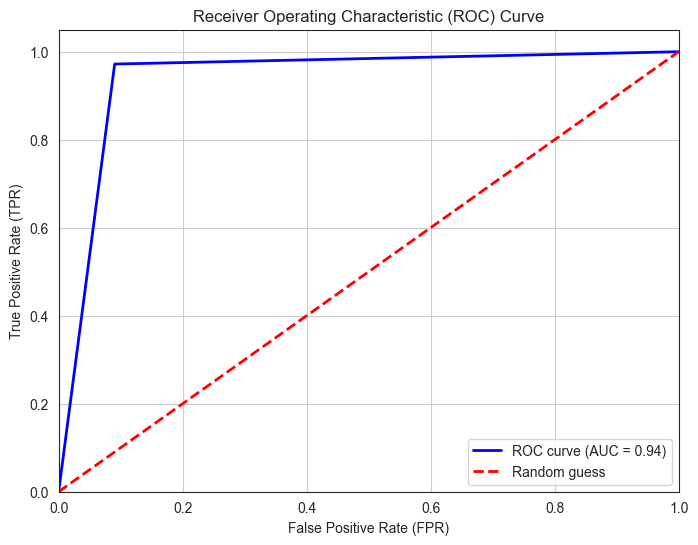

In [99]:
#ROC-AUC curve
binarySVM_fpr, binarySVM_tpr, binarySVM_thresholds = roc_curve(baseY_test, binarySVM_ypred_test)
binarySVM_roc_auc = auc(binarySVM_fpr, binarySVM_tpr)
print(binarySVM_roc_auc)

plt.figure(figsize=(8, 6))
plt.plot(binarySVM_fpr, binarySVM_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % binarySVM_roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [131]:
ldaSVM_ypred_train = ldaSVM.predict(baseX_train)
ldaSVM_ypred_test = ldaSVM.predict(baseX_test)

In [132]:
svmLDA_cm_train = confusion_matrix(baseY_train, ldaSVM_ypred_train)
print(svmLDA_cm_train)

print(classification_report(baseY_train, ldaSVM_ypred_train))

svmLDA_cm_test = confusion_matrix(baseY_test, ldaSVM_ypred_test)
print(svmLDA_cm_test)

print(classification_report(baseY_test, ldaSVM_ypred_test))

[[1207   68]
 [  46 2243]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1275
           1       0.97      0.98      0.98      2289

    accuracy                           0.97      3564
   macro avg       0.97      0.96      0.97      3564
weighted avg       0.97      0.97      0.97      3564

[[304  17]
 [ 10 561]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       321
           1       0.97      0.98      0.98       571

    accuracy                           0.97       892
   macro avg       0.97      0.96      0.97       892
weighted avg       0.97      0.97      0.97       892



In [134]:
lda_SVM_residuals_train = baseY_train - ldaSVM_ypred_train
lda_SVM_var_train = np.var(lda_SVM_residuals_train)
print(f"LDA Logistic Regression Variance (Training Data): {lda_SVM_var_train}")

lda_SVM_residuals_test = baseY_test - ldaSVM_ypred_test
lda_SVM_var_test = np.var(lda_SVM_residuals_test)
print(f"LDA Logistic Regression Variance (Test Data): {lda_SVM_var_test}")

LDA Logistic Regression Variance (Training Data): 0.031948428038963014
LDA Logistic Regression Variance (Test Data): 0.03020747451185425


In [136]:
lda_SVM_decision_scores_train = ldaSVM.decision_function(baseX_train)
lda_SVM_hinge_loss_train = np.maximum(0, 1 - ldaSVM_ypred_train * lda_SVM_decision_scores_train).mean()
print(f"LDA SVM Hinge Loss (Train): {lda_SVM_hinge_loss_train}")

lda_SVM_decision_scores_test = ldaSVM.decision_function(baseX_test)
lda_SVM_hinge_loss_test = np.maximum(0, 1 - ldaSVM_ypred_test * lda_SVM_decision_scores_test).mean()
print(f"LDA SVM Hinge Loss (Test): {lda_SVM_hinge_loss_test}")

LDA SVM Hinge Loss (Train): 0.3925783811063803
LDA SVM Hinge Loss (Test): 0.38775255010449583


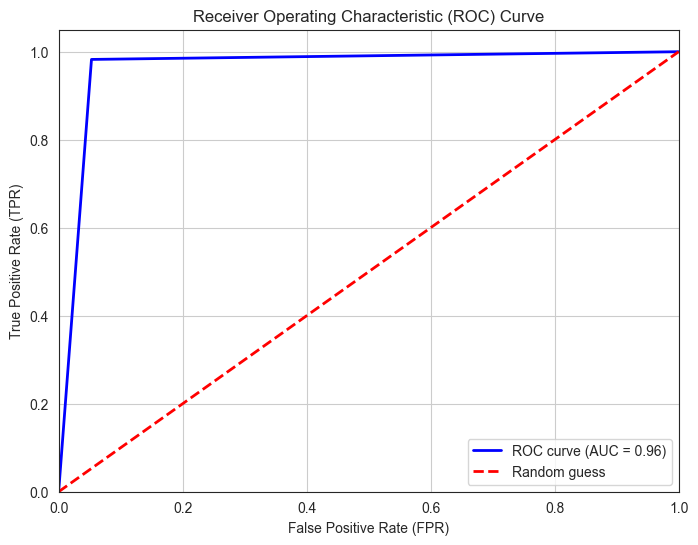

In [138]:
#ROC-AUC curve
ldaSVM_fpr, ldaSVM_tpr, ldaSVM_thresholds = roc_curve(baseY_test, ldaSVM_ypred_test)
roc_auc = auc(ldaSVM_fpr, ldaSVM_tpr)

plt.figure(figsize=(8, 6))
plt.plot(ldaSVM_fpr, ldaSVM_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Save trained models into pickle file for re-use

In [ ]:
import pickle

pickle.dump(logregBase , open('logregBase.pkl' , 'wb'))
pickle.dump(logregBinary , open('logregBinary.pkl' , 'wb'))
pickle.dump(logregLDA, open('logregLDA.pkl' , 'wb'))


pickle.dump(base_svm , open('base_svm.pkl' , 'wb'))
pickle.dump(binary_svm , open('binary_svm.pkl' , 'wb'))
pickle.dump(lda_svm , open('lda_svm.pkl' , 'wb'))

#### mcSVM Models for Classification of Severity

We will train using two different kernels and check the classification report. Kernels used are rbf and polynomial

In [95]:
rbf = SVC(kernel = 'rbf')
poly = SVC(kernel = 'poly')

rbfBinary = SVC(kernel = 'rbf') #we will only be using rbf kernel for binary to target specific locations

In [98]:
rbf.fit(mcSVM_images, mcSVM_lab)

SVC()

In [99]:
rbfBinary.fit(binary_mcSVM, mcSVM_lab)

SVC()

In [100]:
poly.fit(mcSVM_images, mcSVM_lab)

SVC(kernel='poly')

In [102]:
pickle.dump(rbf , open('rbf.pkl' , 'wb'))
pickle.dump(poly , open('poly.pkl' , 'wb'))
pickle.dump(rbfBinary, open('rbfBinary.pkl' , 'wb'))

In [28]:
with open ('poly.pkl', 'rb') as file:
    polySVM = pickle.load(file)

with open ('rbf.pkl', 'rb') as file:
    rbfSVM = pickle.load(file)

with open ('rbfBinary.pkl', 'rb') as file:
    rbfBinarySVM = pickle.load(file)

##### mcSVM Results

In [147]:
polySVM_ypred_train = polySVM.predict(mcSVM_X_train)
polySVM_ypred_test = polySVM.predict(mcSVM_X_test)

In [146]:
print(f"Poly SVM Prediction Probability: {np.mean(polySVM_ypred)}")
print(f"Actual Probability: {np.mean(baseY_test)}")

rbfSVM_ypred = rbfSVM.predict(mcSVM_X_test)
print(f"RBF SVM Prediction Probability: {np.mean(rbfSVM_ypred)}")
print(f"Actual Probability: {np.mean(binaryY_test)}")

rbfBinarySVM_ypred = rbfBinarySVM.predict(mcSVM_binary_X_test)
print(f"Binary RBF SVM Prediction Probability: {np.mean(rbfBinarySVM_ypred)}")
print(f"Actual Probability: {np.mean(baseY_test)}")

Poly SVM Prediction Probability: 1.137062937062937
Actual Probability: 0.6401345291479821
RBF SVM Prediction Probability: 1.165034965034965
Actual Probability: 0.6401345291479821
Binary RBF SVM Prediction Probability: 1.067132867132867
Actual Probability: 0.6401345291479821


In [151]:
print("Poly Multiclass SVM Metrics for Training Data")
poly_cm_train = confusion_matrix(mcSVM_y_train, polySVM_ypred_train)
print(poly_cm_train)
print(classification_report(polySVM_ypred_train, mcSVM_y_train))

print("Poly Multiclass SVM Metrics for Test Data")
poly_cm_test = confusion_matrix(mcSVM_y_test, polySVM_ypred_test)
print(poly_cm_test)
print(classification_report(poly_ypred, mcSVM_y_test))

Poly Multiclass SVM Metrics for Training Data
[[679   0   2]
 [  0 593   0]
 [ 11   0 860]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       690
           1       1.00      1.00      1.00       593
           2       0.99      1.00      0.99       862

    accuracy                           0.99      2145
   macro avg       0.99      0.99      0.99      2145
weighted avg       0.99      0.99      0.99      2145

Poly Multiclass SVM Metrics for Test Data
[[215   0   0]
 [  0 175   0]
 [  6   0 319]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       221
           1       1.00      1.00      1.00       175
           2       0.98      1.00      0.99       319

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



In [154]:
poly_residuals_train = mcSVM_y_train - polySVM_ypred_train
poly_var_train = np.var(poly_residuals_train)
print(f"Poly Multiclass SVM Variance (Training Data): {poly_var_train}")

poly_residuals_test = mcSVM_y_test - polySVM_ypred_test
poly_var_test = np.var(poly_residuals_test)
print(f"Poly Multiclass SVM Variance (Test Data): {poly_var_test}")

Poly Multiclass SVM Variance (Training Data): 0.024172005151026126
Poly Multiclass SVM Variance (Test Data): 0.03328475720084113


In [160]:
rbf_ypred = rbf.predict(mcSVM_X_test)
print(classification_report(rbf_ypred, mcSVM_y_test))

'              precision    recall  f1-score   support\n\n           0       0.83      0.86      0.85       206\n           1       1.00      1.00      1.00       175\n           2       0.91      0.89      0.90       334\n\n    accuracy                           0.91       715\n   macro avg       0.91      0.92      0.92       715\nweighted avg       0.91      0.91      0.91       715\n'

In [ ]:
rbfBinary_ypred = rbfBinary.predict(mcSVM_binary_X_test)
print(classification_report(rbfBinary_ypred, mcSVM_binary_y_test))

'              precision    recall  f1-score   support\n\n           0       0.92      0.95      0.93       209\n           1       1.00      1.00      1.00       175\n           2       0.97      0.95      0.96       331\n\n    accuracy                           0.96       715\n   macro avg       0.96      0.97      0.96       715\nweighted avg       0.96      0.96      0.96       715\n'

In [ ]:
pickle.dump(rbf , open('rbf.pkl' , 'wb'))
pickle.dump(poly , open('poly.pkl' , 'wb'))
pickle.dump(rbfBinary, open('rbfBinary.pkl' , 'wb'))


#### Overall Method using Deep-Learning

#### CNN Model for Detection & Classification

In [103]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (175,145,1), padding = 'same'))
model.add(layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.1)) #regularization

model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.1))


model.add(layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.BatchNormalization())


model.add(layers.Dense(4, activation='softmax'))

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [114]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 175, 145, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 175, 145, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 87, 72, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 87, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 87, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 87, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 43, 36, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 43, 36, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 43, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 21, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 9, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 9, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 9, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 9, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 9, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             

 Total params: 11,633,310 (44.38 MB)

 Trainable params: 3,876,980 (14.79 MB)

 Non-trainable params: 2,368 (9.25 KB)

 Optimizer params: 7,753,962 (29.58 MB)

In [117]:
opt = keras.optimizers.Adam(learning_rate = 0.000001)
model.compile(optimizer= opt, loss= 'categorical_crossentropy', metrics= ['accuracy', 'precision', 'recall'])

In [118]:
cnn_X_train = baseImages3D
cnn_y_train = cnn_labels

In [119]:
history = model.fit(cnn_X_train, cnn_y_train, epochs = 10)

Epoch 1/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 128s 566ms/step - accuracy: 0.8993 - loss: 0.2400 - precision: 0.9027 - recall: 0.8942
Epoch 2/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 128s 594ms/step - accuracy: 0.9043 - loss: 0.2307 - precision: 0.9061 - recall: 0.9005
Epoch 3/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 125s 577ms/step - accuracy: 0.9002 - loss: 0.2270 - precision: 0.9018 - recall: 0.8967
Epoch 4/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 123s 570ms/step - accuracy: 0.9032 - loss: 0.2249 - precision: 0.9063 - recall: 0.9007
Epoch 5/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 122s 565ms/step - accuracy: 0.9045 - loss: 0.2236 - precision: 0.9085 - recall: 0.9016
Epoch 6/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 122s 565ms/step - accuracy: 0.9073 - loss: 0.2269 - precision: 0.9096 - recall: 0.9035
Epoch 7/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 122s 567ms/step - accuracy: 0.9021 - loss: 0.2282 - precision: 0.9042 - recall: 0.8994
Epoch 8/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 122s 566ms/step - accuracy: 0.9037 - loss: 0.2302 - precision: 0.9061 -

In [121]:
model.save('cnnh5.keras')

In [145]:
cnn = load_model('cnnh5.h5')
opt = keras.optimizers.Adam(learning_rate = 0.0008)
cnn.compile(optimizer= opt, loss= 'categorical_crossentropy', metrics= ['accuracy', 'precision', 'recall'])
cnn_metrics = cnn.fit(cnn_X_train, cnn_y_train, epochs = 10)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 709ms/step - accuracy: 0.8372 - loss: 0.4323 - precision: 0.8514 - recall: 0.8271
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 726ms/step - accuracy: 0.8939 - loss: 0.2709 - precision: 0.9064 - recall: 0.8845
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 79s 703ms/step - accuracy: 0.9268 - loss: 0.2060 - precision: 0.9335 - recall: 0.9223
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 741ms/step - accuracy: 0.9512 - loss: 0.1462 - precision: 0.9533 - recall: 0.9453
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 88s 782ms/step - accuracy: 0.9613 - loss: 0.1237 - precision: 0.9652 - recall: 0.9560
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 89s 792ms/step - accuracy: 0.9631 - loss: 0.1113 - precision: 0.9662 - recall: 0.9603
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 89s 796ms/step - accuracy: 0.9660 - loss: 0.1029 - precision: 0.9694 - recall: 0.9636
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 89s 799ms/step - accuracy: 0.9639 - loss: 0.1089 - precision: 0.9664 - recall: